# An Introduction to Variational Autoencoders

# Imports

In [1]:
# For working with and visualizing the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For training the VAE
import tensorflow as tf

# For creating interactive widgets
import ipywidgets as widgets
from IPython.display import display

2024-06-27 05:17:41.140165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 05:17:41.140246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 05:17:41.141905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 05:17:41.150269: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the data from a .csv file
pixel_data = pd.read_csv('/workspace/Day 9/age_gender.csv')['pixels']

In [3]:
# Shuffle the data
pixel_data = pixel_data.sample(frac=1.0, random_state=1)  # Shuffle the DataFrame with a fixed random state for reproducibility

# Convert the data into a NumPy array
pixel_data = pixel_data.apply(lambda x: np.array(x.split(" "), dtype=np.int32))  # Split each string into a list of integers and convert to NumPy array with int32 dtype
pixel_data = np.stack(np.array(pixel_data), axis=0)  # Stack the arrays into a single NumPy array

# Rescale pixel values to be between 0 and 1
pixel_data = pixel_data * (1.0 / 255)  # Scale the pixel values to the range [0, 1]

In [4]:
# The data is now a NumPy array of 23705 images (each represented as a 1-D vector of 2304 pixels)
# (2304 is 48^2, so we are working with 48x48x1 images)
pixel_data.shape

(23705, 2304)

# Building the VAE  
  
We need to create a custom Sampling layer to sample the latent variables from a normal distribution with mean and variance given by the encoder.

In [5]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs  # Unpack the inputs into mean and log-variance
        batch = tf.shape(z_mean)[0]  # Get the batch size
        dim = tf.shape(z_mean)[1]  # Get the dimensionality of the latent space
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Sample from standard normal distribution
        return epsilon * tf.exp(z_log_var * 0.5) + z_mean  # Apply the reparameterization trick

In [6]:
def build_vae(num_pixels, num_latent_vars=3):
    
    # Encoder
    encoder_inputs = tf.keras.Input(shape=(num_pixels,))  # Input layer for the encoder
    x = tf.keras.layers.Dense(512, activation='relu')(encoder_inputs)  # First dense layer with 512 units and ReLU activation
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Second dense layer with 128 units and ReLU activation
    x = tf.keras.layers.Dense(32, activation='relu')(x)  # Third dense layer with 32 units and ReLU activation
    z_mean = tf.keras.layers.Dense(num_latent_vars)(x)  # Dense layer for the mean of the latent variables
    z_log_var = tf.keras.layers.Dense(num_latent_vars)(z_mean)  # Dense layer for the log-variance of the latent variables
    z = Sampling()([z_mean, z_log_var])  # Sampling layer to sample the latent variables using the reparameterization trick
    
    encoder = tf.keras.Model(inputs=encoder_inputs, outputs=z)  # Define the encoder model
    
    # Decoder
    decoder_inputs = tf.keras.Input(shape=(num_latent_vars,))  # Input layer for the decoder
    x = tf.keras.layers.Dense(32, activation='relu')(decoder_inputs)  # First dense layer with 32 units and ReLU activation
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Second dense layer with 128 units and ReLU activation
    x = tf.keras.layers.Dense(512, activation='relu')(x)  # Third dense layer with 512 units and ReLU activation
    reconstruction = tf.keras.layers.Dense(num_pixels, activation='linear')(x)  # Output dense layer with 'num_pixels' units and linear activation
    
    decoder = tf.keras.Model(inputs=decoder_inputs, outputs=reconstruction)  # Define the decoder model
    
    # Full model
    model_inputs = encoder.input  # Inputs of the full VAE model are the inputs of the encoder
    model_outputs = decoder(encoder.output)  # Outputs of the full VAE model are the outputs of the decoder, given the encoder's output
    
    model = tf.keras.Model(inputs=model_inputs, outputs=model_outputs)  # Define the full VAE model
    
    # Compile model for training
    model.compile(
        optimizer='adam',  # Adam optimizer
        loss='mse'  # Mean Squared Error (MSE) loss function
    )
    
    # Return all three models
    return encoder, decoder, model  # Return the encoder, decoder, and full VAE models


In [7]:
face_encoder, face_decoder, face_model = build_vae(num_pixels=2304, num_latent_vars=3)

2024-06-27 05:17:49.168208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2970 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:47:00.0, compute capability: 8.0


In [8]:
print(face_encoder.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2304)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 512)                  1180160   ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  65664     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 32)                   4128      ['dense_1[0][0]']             
                                                                                              

In [9]:
print(face_decoder.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_5 (Dense)             (None, 32)                128       
                                                                 
 dense_6 (Dense)             (None, 128)               4224      
                                                                 
 dense_7 (Dense)             (None, 512)               66048     
                                                                 
 dense_8 (Dense)             (None, 2304)              1181952   
                                                                 
Total params: 1252352 (4.78 MB)
Trainable params: 1252352 (4.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


# Train the VAE  
  
We will use *pixel_data* as both the input to the model and the target to compare the output to.

In [10]:
history = face_model.fit(
    pixel_data,
    pixel_data,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100


2024-06-27 05:17:51.587242: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6aa0afc6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-27 05:17:51.587279: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2024-06-27 05:17:51.593598: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-27 05:17:51.637878: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
I0000 00:00:1719465471.757654  237201 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 [==============================] - 6s 4ms/step - loss: 0.0260 - val_loss: 0.0219
Epoch 2/100
593/593 [==============================] - 2s 3ms/step - loss: 0.0217 - val_loss: 0.0216
Epoch 3/100
593/593 [==============================] - 2s 4ms/step - loss: 0.0215 - val_loss: 0.0215
Epoch 4/100
593/593 [==============================] - 2s 4ms/step - loss: 0.0214 - val_loss: 0.0214
Epoch 5/100
593/593 [==============================] - 2s 3ms/step - loss: 0.0213 - val_loss: 0.0212
Epoch 6/100
593/593 [==============================] - 2s 3ms/step - loss: 0.0212 - val_loss: 0.0212
Epoch 7/100
593/593 [==============================] - 2s 3ms/step - loss: 0.0211 - val_loss: 0.0215
Epoch 8/100
593/593 [==============================] - 2s 3ms/step - loss: 0.0210 - val_loss: 0.0209
Epoch 9/100
593/593 [==============================] - 2s 4ms/step - loss: 0.0209 - val_loss: 0.0209
Epoch 10/100
593/593 [==============================] - 2s 4ms/step - loss: 0.0209 - val_loss: 0.0210
E

# Image Reconstruction  
  
Let's see how the model does at reconstructing an image that it has already seen.

741/741 [==============================] - 1s 1ms/step


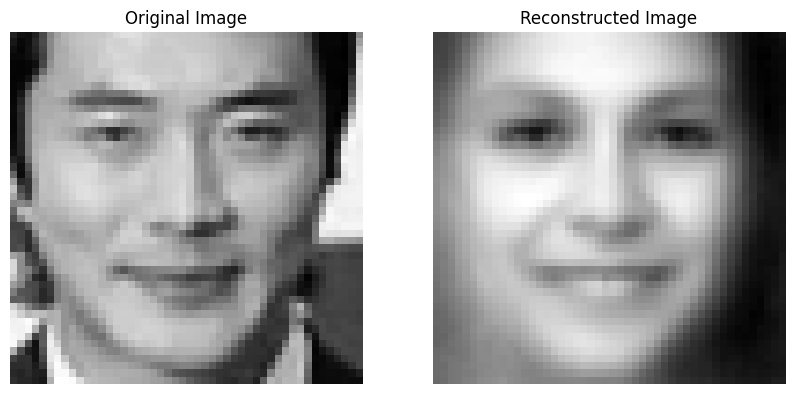

In [11]:
i = 6  # Index of the image to be displayed

sample = np.array(pixel_data)[i].copy()  # Copy the original image data at index i
sample = sample.reshape(48, 48, 1)  # Reshape the image to 48x48x1

reconstruction = face_model.predict(pixel_data)[i].copy()  # Predict and copy the reconstructed image at index i
reconstruction = reconstruction.reshape(48, 48, 1)  # Reshape the reconstructed image to 48x48x1

plt.figure(figsize=(10, 5))  # Create a figure with a specified size

plt.subplot(1, 2, 1)  # Add a subplot in a 1x2 grid at position 1
plt.imshow(sample, cmap='gray')  # Display the original image in grayscale
plt.axis('off')  # Turn off axis labels
plt.title("Original Image")  # Set the title for the original image

plt.subplot(1, 2, 2)  # Add a subplot in a 1x2 grid at position 2
plt.imshow(reconstruction, cmap='gray')  # Display the reconstructed image in grayscale
plt.axis('off')  # Turn off axis labels
plt.title("Reconstructed Image")  # Set the title for the reconstructed image

plt.show()  # Display the figure with both subplots

# Specify our own latent variable values  
  
Now let's see how we can use our own values to generate never-before-seen images.

In [12]:
# A function to allow us to specify our own latent variable values and plot the constructed image
def generate_face_image(latent1, latent2, latent3):
    latent_vars = np.array([[latent1, latent2, latent3]])  # Create a numpy array with the provided latent variables
    reconstruction = np.array(face_decoder(latent_vars))  # Decode the latent variables to reconstruct the image
    reconstruction = reconstruction.reshape(48, 48, 1)  # Reshape the reconstruction to the original image dimensions
    plt.figure()  # Create a new figure for the plot
    plt.imshow(reconstruction, cmap='gray')  # Display the image in grayscale
    plt.axis('off')  # Turn off the axis
    plt.show()  # Show the plot

In [13]:
# Let's get the min and max for each slider on the interactive widget

# Calculate the minimum value for the first latent dimension
latent1_min = np.min(face_encoder(pixel_data).numpy()[:, 0])  
# Calculate the maximum value for the first latent dimension
latent1_max = np.max(face_encoder(pixel_data).numpy()[:, 0])  

# Calculate the minimum value for the second latent dimension
latent2_min = np.min(face_encoder(pixel_data).numpy()[:, 1])  
# Calculate the maximum value for the second latent dimension
latent2_max = np.max(face_encoder(pixel_data).numpy()[:, 1])  

# Calculate the minimum value for the third latent dimension
latent3_min = np.min(face_encoder(pixel_data).numpy()[:, 2])  
# Calculate the maximum value for the third latent dimension
latent3_max = np.max(face_encoder(pixel_data).numpy()[:, 2])  

In [14]:
import tensorflow as tf
print(tf.__version__)


2.15.0


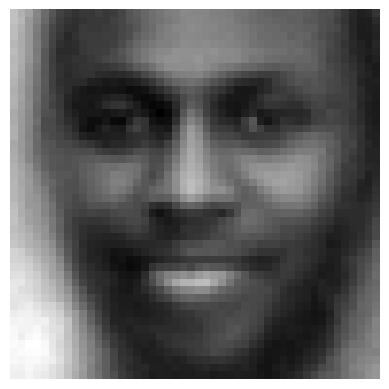

interactive(children=(FloatSlider(value=-3.034311294555664, description='latent1', max=10.798378944396973, min…

<function __main__.generate_face_image(latent1, latent2, latent3)>

In [15]:
# Create the interactive widget
face_image_generator = widgets.interact(  # Initialize the interactive widget
    generate_face_image,  # Function to call when the widget's value changes
    latent1=(latent1_min, latent1_max),  # Slider for latent1 with min and max values
    latent2=(latent2_min, latent2_max),  # Slider for latent2 with min and max values
    latent3=(latent3_min, latent3_max),  # Slider for latent3 with min and max values
)

# Display the widget
display(face_image_generator)  # Render the widget in the output cell